In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-13 15:09:19.446770: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 15:09:19.493791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 15:09:21.591221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_simple_variable.csv')
test = pd.read_csv('./data/test_simple_variable.csv')

# Solo

In [5]:
X = train.drop(columns=['target'])
y= train['target'].apply(lambda x: 0 if x == 'Normal' else 1)

# cat_features_indices = ['model_suffix', 'pallet', 'receip']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-13 15:09:26,023] A new study created in memory with name: no-name-9ef1a436-64f2-482f-8b3a-4fac66524a6a
[I 2024-08-13 15:09:40,402] Trial 0 finished with value: 0.056562399836958634 and parameters: {'iterations': 528, 'depth': 7, 'learning_rate': 0.006129898565633916, 'l2_leaf_reg': 1.6498527593277623, 'border_count': 144, 'random_strength': 3.6593811387952484, 'bagging_temperature': 0.7245084970058875, 'od_type': 'Iter', 'od_wait': 33, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.056562399836958634.
[I 2024-08-13 15:09:41,495] Trial 1 finished with value: 0.0543525858473142 and parameters: {'iterations': 275, 'depth': 5, 'learning_rate': 0.020003567858043497, 'l2_leaf_reg': 8.016891916761239, 'border_count': 116, 'random_strength': 4.122110257897117, 'bagging_temperature': 0.9417569448511859, 'od_type': 'IncToDec', 'od_wait': 27, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.056562399836958634.
[I 2024-08-13 15:09:44,731] Trial 2 finished with value:

[I 2024-08-13 15:11:43,600] Trial 20 finished with value: 0.056562399836958634 and parameters: {'iterations': 557, 'depth': 10, 'learning_rate': 0.0204940852095203, 'l2_leaf_reg': 5.626180602792678, 'border_count': 84, 'random_strength': 0.1144317387398921, 'bagging_temperature': 0.49916823352278233, 'od_type': 'Iter', 'od_wait': 33, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.056562399836958634.
[I 2024-08-13 15:11:45,954] Trial 21 finished with value: 0.056562399836958634 and parameters: {'iterations': 324, 'depth': 8, 'learning_rate': 0.011980466169219883, 'l2_leaf_reg': 5.417309081050034, 'border_count': 38, 'random_strength': 1.5956112889418155, 'bagging_temperature': 0.6493879426313388, 'od_type': 'IncToDec', 'od_wait': 26, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.056562399836958634.
[I 2024-08-13 15:11:47,516] Trial 22 finished with value: 0.056562399836958634 and parameters: {'iterations': 389, 'depth': 8, 'learning_rate': 0.01732892681912159, 'l2

[I 2024-08-13 15:12:28,240] Trial 40 finished with value: 0.0543525858473142 and parameters: {'iterations': 357, 'depth': 4, 'learning_rate': 0.8222876632349414, 'l2_leaf_reg': 6.134174165268629, 'border_count': 111, 'random_strength': 6.768120587106987, 'bagging_temperature': 0.39257879855635774, 'od_type': 'Iter', 'od_wait': 21, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.056562399836958634.
[I 2024-08-13 15:12:31,047] Trial 41 finished with value: 0.058466467728809084 and parameters: {'iterations': 476, 'depth': 10, 'learning_rate': 0.6347242246510775, 'l2_leaf_reg': 0.7850393774153468, 'border_count': 181, 'random_strength': 1.6173772037035434, 'bagging_temperature': 0.7856978042924547, 'od_type': 'IncToDec', 'od_wait': 48, 'boosting_type': 'Ordered'}. Best is trial 41 with value: 0.058466467728809084.
[I 2024-08-13 15:12:33,844] Trial 42 finished with value: 0.058466467728809084 and parameters: {'iterations': 515, 'depth': 10, 'learning_rate': 0.6670673727613726, 'l

Best trial:
  Value: 0.06090527769872346
  Params: 
    iterations: 607
    depth: 10
    learning_rate: 0.31054349476242743
    l2_leaf_reg: 0.012436469067378303
    border_count: 185
    random_strength: 2.3303130143324053
    bagging_temperature: 0.950751468639525
    od_type: IncToDec
    od_wait: 46
    boosting_type: Ordered


In [6]:
study.best_trial.params

{'iterations': 607,
 'depth': 10,
 'learning_rate': 0.31054349476242743,
 'l2_leaf_reg': 0.012436469067378303,
 'border_count': 185,
 'random_strength': 2.3303130143324053,
 'bagging_temperature': 0.950751468639525,
 'od_type': 'IncToDec',
 'od_wait': 46,
 'boosting_type': 'Ordered'}

In [7]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

0:	learn: 0.3927819	total: 71.6ms	remaining: 43.4s
1:	learn: 0.2805389	total: 140ms	remaining: 42.3s
2:	learn: 0.2388293	total: 209ms	remaining: 42.1s
3:	learn: 0.2219809	total: 275ms	remaining: 41.4s
4:	learn: 0.2151276	total: 339ms	remaining: 40.8s
5:	learn: 0.2114617	total: 397ms	remaining: 39.7s
6:	learn: 0.2100661	total: 464ms	remaining: 39.8s
7:	learn: 0.2093711	total: 493ms	remaining: 36.9s
8:	learn: 0.2088108	total: 509ms	remaining: 33.8s
9:	learn: 0.2082054	total: 573ms	remaining: 34.2s
10:	learn: 0.2080709	total: 638ms	remaining: 34.6s
11:	learn: 0.2079289	total: 697ms	remaining: 34.6s
12:	learn: 0.2078342	total: 723ms	remaining: 33.1s
13:	learn: 0.2077420	total: 791ms	remaining: 33.5s
14:	learn: 0.2076808	total: 850ms	remaining: 33.5s
15:	learn: 0.2076630	total: 886ms	remaining: 32.7s
16:	learn: 0.2076626	total: 898ms	remaining: 31.2s
17:	learn: 0.2076040	total: 961ms	remaining: 31.4s
18:	learn: 0.2076008	total: 980ms	remaining: 30.3s
19:	learn: 0.2075892	total: 1.03s	remain

161:	learn: 0.2056843	total: 8.81s	remaining: 24.2s
162:	learn: 0.2056842	total: 8.88s	remaining: 24.2s
163:	learn: 0.2056758	total: 8.94s	remaining: 24.1s
164:	learn: 0.2056753	total: 8.99s	remaining: 24.1s
165:	learn: 0.2056751	total: 9.04s	remaining: 24s
166:	learn: 0.2056751	total: 9.08s	remaining: 23.9s
167:	learn: 0.2056727	total: 9.13s	remaining: 23.9s
168:	learn: 0.2056724	total: 9.19s	remaining: 23.8s
169:	learn: 0.2056723	total: 9.22s	remaining: 23.7s
170:	learn: 0.2056723	total: 9.25s	remaining: 23.6s
171:	learn: 0.2056699	total: 9.3s	remaining: 23.5s
172:	learn: 0.2056697	total: 9.36s	remaining: 23.5s
173:	learn: 0.2056683	total: 9.41s	remaining: 23.4s
174:	learn: 0.2056683	total: 9.46s	remaining: 23.4s
175:	learn: 0.2056651	total: 9.51s	remaining: 23.3s
176:	learn: 0.2056638	total: 9.57s	remaining: 23.2s
177:	learn: 0.2056633	total: 9.63s	remaining: 23.2s
178:	learn: 0.2056633	total: 9.65s	remaining: 23.1s
179:	learn: 0.2056629	total: 9.71s	remaining: 23s
180:	learn: 0.205

320:	learn: 0.2054766	total: 17.1s	remaining: 15.3s
321:	learn: 0.2054765	total: 17.2s	remaining: 15.2s
322:	learn: 0.2054728	total: 17.2s	remaining: 15.2s
323:	learn: 0.2054721	total: 17.3s	remaining: 15.1s
324:	learn: 0.2054720	total: 17.3s	remaining: 15s
325:	learn: 0.2054712	total: 17.4s	remaining: 15s
326:	learn: 0.2054700	total: 17.4s	remaining: 14.9s
327:	learn: 0.2054700	total: 17.5s	remaining: 14.9s
328:	learn: 0.2054700	total: 17.5s	remaining: 14.8s
329:	learn: 0.2054695	total: 17.6s	remaining: 14.8s
330:	learn: 0.2054595	total: 17.6s	remaining: 14.7s
331:	learn: 0.2054511	total: 17.7s	remaining: 14.7s
332:	learn: 0.2054496	total: 17.7s	remaining: 14.6s
333:	learn: 0.2054494	total: 17.8s	remaining: 14.5s
334:	learn: 0.2054493	total: 17.9s	remaining: 14.5s
335:	learn: 0.2054478	total: 17.9s	remaining: 14.4s
336:	learn: 0.2054474	total: 18s	remaining: 14.4s
337:	learn: 0.2054469	total: 18s	remaining: 14.3s
338:	learn: 0.2054466	total: 18.1s	remaining: 14.3s
339:	learn: 0.205445

480:	learn: 0.2053748	total: 25.7s	remaining: 6.74s
481:	learn: 0.2053748	total: 25.8s	remaining: 6.68s
482:	learn: 0.2053748	total: 25.8s	remaining: 6.63s
483:	learn: 0.2053748	total: 25.9s	remaining: 6.58s
484:	learn: 0.2053748	total: 25.9s	remaining: 6.52s
485:	learn: 0.2053740	total: 26s	remaining: 6.47s
486:	learn: 0.2053734	total: 26s	remaining: 6.42s
487:	learn: 0.2053731	total: 26.1s	remaining: 6.36s
488:	learn: 0.2053727	total: 26.1s	remaining: 6.31s
489:	learn: 0.2053724	total: 26.2s	remaining: 6.25s
490:	learn: 0.2053723	total: 26.3s	remaining: 6.2s
491:	learn: 0.2053721	total: 26.3s	remaining: 6.15s
492:	learn: 0.2053721	total: 26.3s	remaining: 6.09s
493:	learn: 0.2053721	total: 26.4s	remaining: 6.04s
494:	learn: 0.2053721	total: 26.4s	remaining: 5.98s
495:	learn: 0.2053720	total: 26.5s	remaining: 5.93s
496:	learn: 0.2053719	total: 26.5s	remaining: 5.87s
497:	learn: 0.2053718	total: 26.6s	remaining: 5.82s
498:	learn: 0.2053718	total: 26.6s	remaining: 5.76s
499:	learn: 0.205

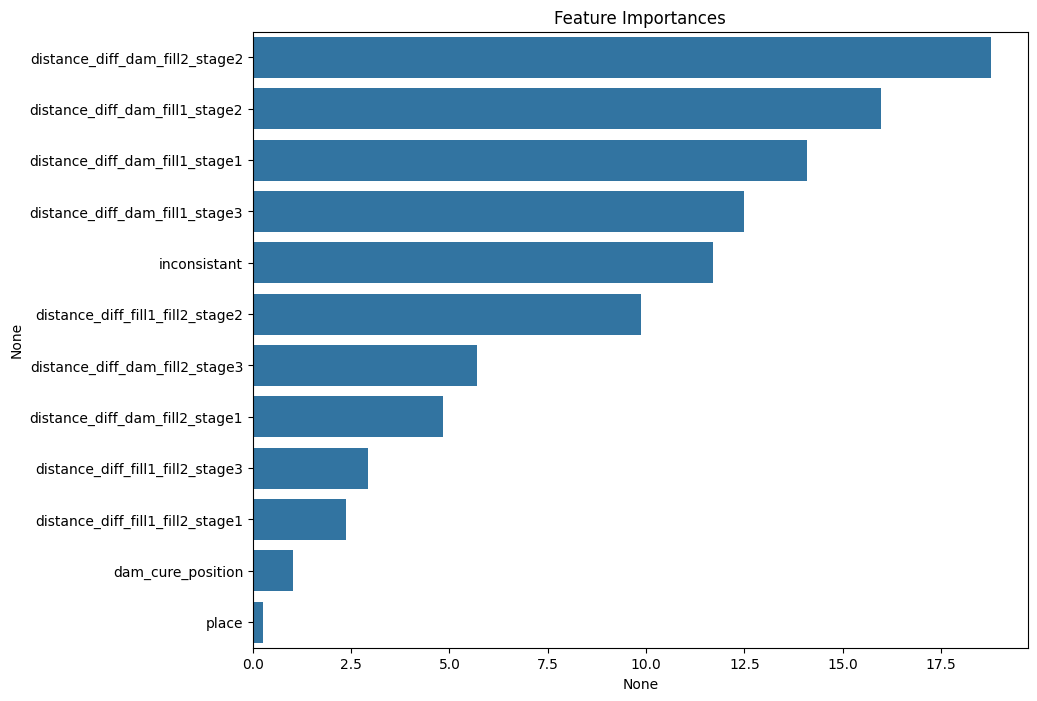

In [8]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [9]:
pred = best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  22  436]
 [   0 7644]]

정확도: 0.9462
정밀도: 1.0000
재현율: 0.0480
F1: 0.0917


# 추론

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(X, y)

0:	learn: 0.3981802	total: 31.4ms	remaining: 19s
1:	learn: 0.2853766	total: 104ms	remaining: 31.4s
2:	learn: 0.2436244	total: 125ms	remaining: 25.1s
3:	learn: 0.2237093	total: 193ms	remaining: 29.1s
4:	learn: 0.2163918	total: 234ms	remaining: 28.2s
5:	learn: 0.2133548	total: 257ms	remaining: 25.7s
6:	learn: 0.2119949	total: 314ms	remaining: 26.9s
7:	learn: 0.2100035	total: 354ms	remaining: 26.5s
8:	learn: 0.2089729	total: 409ms	remaining: 27.2s
9:	learn: 0.2086167	total: 466ms	remaining: 27.8s
10:	learn: 0.2084310	total: 494ms	remaining: 26.8s
11:	learn: 0.2081547	total: 524ms	remaining: 26s
12:	learn: 0.2078915	total: 594ms	remaining: 27.1s
13:	learn: 0.2078706	total: 659ms	remaining: 27.9s
14:	learn: 0.2077966	total: 720ms	remaining: 28.4s
15:	learn: 0.2077598	total: 781ms	remaining: 28.9s
16:	learn: 0.2076710	total: 821ms	remaining: 28.5s
17:	learn: 0.2076248	total: 849ms	remaining: 27.8s
18:	learn: 0.2075538	total: 917ms	remaining: 28.4s
19:	learn: 0.2075465	total: 931ms	remaining:

164:	learn: 0.2059019	total: 8.94s	remaining: 23.9s
165:	learn: 0.2058426	total: 9.01s	remaining: 23.9s
166:	learn: 0.2058259	total: 9.07s	remaining: 23.9s
167:	learn: 0.2058252	total: 9.09s	remaining: 23.8s
168:	learn: 0.2058211	total: 9.16s	remaining: 23.8s
169:	learn: 0.2058195	total: 9.22s	remaining: 23.7s
170:	learn: 0.2058176	total: 9.28s	remaining: 23.7s
171:	learn: 0.2058168	total: 9.34s	remaining: 23.6s
172:	learn: 0.2058166	total: 9.38s	remaining: 23.5s
173:	learn: 0.2058164	total: 9.39s	remaining: 23.4s
174:	learn: 0.2058163	total: 9.41s	remaining: 23.2s
175:	learn: 0.2058163	total: 9.44s	remaining: 23.1s
176:	learn: 0.2058162	total: 9.47s	remaining: 23s
177:	learn: 0.2058158	total: 9.53s	remaining: 23s
178:	learn: 0.2058154	total: 9.59s	remaining: 22.9s
179:	learn: 0.2057875	total: 9.65s	remaining: 22.9s
180:	learn: 0.2057873	total: 9.71s	remaining: 22.9s
181:	learn: 0.2057864	total: 9.77s	remaining: 22.8s
182:	learn: 0.2057863	total: 9.81s	remaining: 22.7s
183:	learn: 0.20

327:	learn: 0.2056397	total: 17s	remaining: 14.5s
328:	learn: 0.2056396	total: 17.1s	remaining: 14.4s
329:	learn: 0.2056395	total: 17.1s	remaining: 14.4s
330:	learn: 0.2056394	total: 17.2s	remaining: 14.3s
331:	learn: 0.2056383	total: 17.2s	remaining: 14.3s
332:	learn: 0.2056381	total: 17.3s	remaining: 14.2s
333:	learn: 0.2056379	total: 17.4s	remaining: 14.2s
334:	learn: 0.2056379	total: 17.4s	remaining: 14.1s
335:	learn: 0.2056379	total: 17.5s	remaining: 14.1s
336:	learn: 0.2056377	total: 17.5s	remaining: 14.1s
337:	learn: 0.2056377	total: 17.6s	remaining: 14s
338:	learn: 0.2056377	total: 17.6s	remaining: 13.9s
339:	learn: 0.2056358	total: 17.7s	remaining: 13.9s
340:	learn: 0.2056358	total: 17.8s	remaining: 13.9s
341:	learn: 0.2056357	total: 17.8s	remaining: 13.8s
342:	learn: 0.2056357	total: 17.9s	remaining: 13.8s
343:	learn: 0.2056332	total: 17.9s	remaining: 13.7s
344:	learn: 0.2056327	total: 18s	remaining: 13.6s
345:	learn: 0.2056326	total: 18s	remaining: 13.6s
346:	learn: 0.205632

487:	learn: 0.2055831	total: 25.1s	remaining: 6.13s
488:	learn: 0.2055830	total: 25.2s	remaining: 6.08s
489:	learn: 0.2055830	total: 25.2s	remaining: 6.03s
490:	learn: 0.2055829	total: 25.3s	remaining: 5.97s
491:	learn: 0.2055824	total: 25.3s	remaining: 5.92s
492:	learn: 0.2055824	total: 25.4s	remaining: 5.87s
493:	learn: 0.2055824	total: 25.4s	remaining: 5.81s
494:	learn: 0.2055823	total: 25.5s	remaining: 5.76s
495:	learn: 0.2055823	total: 25.5s	remaining: 5.71s
496:	learn: 0.2055821	total: 25.5s	remaining: 5.65s
497:	learn: 0.2055801	total: 25.6s	remaining: 5.61s
498:	learn: 0.2055801	total: 25.7s	remaining: 5.55s
499:	learn: 0.2055801	total: 25.7s	remaining: 5.5s
500:	learn: 0.2055797	total: 25.8s	remaining: 5.45s
501:	learn: 0.2055790	total: 25.8s	remaining: 5.4s
502:	learn: 0.2055788	total: 25.9s	remaining: 5.35s
503:	learn: 0.2055787	total: 25.9s	remaining: 5.3s
504:	learn: 0.2055784	total: 26s	remaining: 5.24s
505:	learn: 0.2055784	total: 26s	remaining: 5.18s
506:	learn: 0.20557

In [11]:
# test x
test_x = test[X.columns]

In [12]:
test_pred = best_model.predict(test_x)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
y_pred = np.where(test_pred == 1, "AbNormal", "Normal")

In [14]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([   59, 17302]))

In [15]:
test['target'] = y_pred

In [16]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,31,17302
1,28,0


In [21]:
pd.crosstab([test['inconsistant'], test['place']], test['target'])

target              AbNormal  Normal
inconsistant place                  
0            0            31   17302
1            0            16       0
             1            12       0

In [17]:
import shap

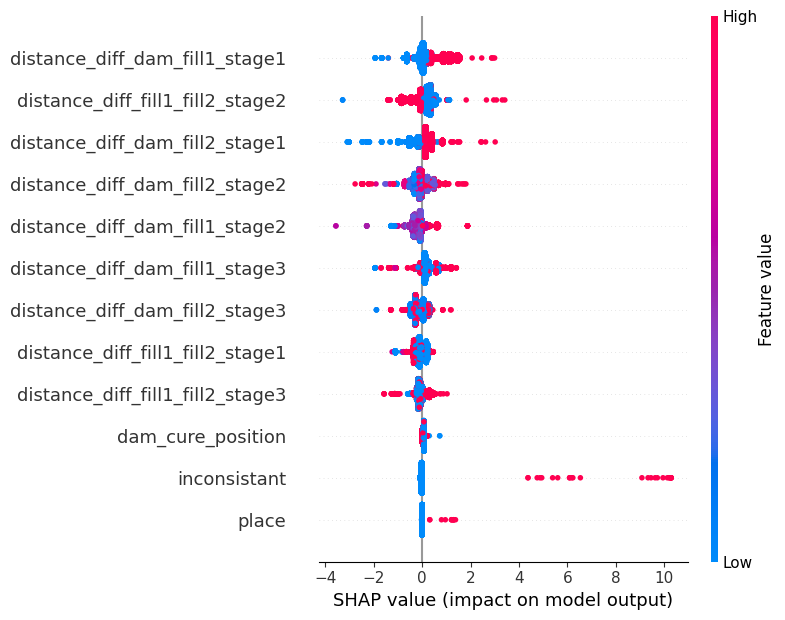

In [18]:
explainer = shap.Explainer(best_model)
shap_values = explainer(test_x)
shap.initjs()

shap.summary_plot(shap_values, test_x)

In [19]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)